<a href="https://colab.research.google.com/github/CSpanias/ml_training/blob/master/RandomForestClassifier_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Random Forest Classifier Algorithm**

*This notebook was developed for Random Forest Classifier practice and the resulting code is a blend of various different resources.*

Based mostly on:
* [SoloLearn Courses (ML Path)](https://www.sololearn.com/learning/1094)



# **CONTENT**

1. [Data Cleaning](#DataCleaning)
2. [Exploratory Data Analysis (EDA)](#EDA)
3. [Hyperparameter Optimization](#GS)
4. [Conclusions](#Conclusions)


In [1]:
import pandas as pd # importing dataset as a "spreadsheet"
import numpy as np # convert DataFrame to arrays, calculate means
import seaborn as sns # visualization
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier # algorithm required
from sklearn.model_selection import train_test_split # split data
from sklearn.model_selection import GridSearchCV # hyperparameter optimization
from sklearn.model_selection import KFold, cross_val_score # perform a KFold Cross-Validation
from sklearn.metrics import accuracy_score, precision_score, recall_score # evaluation metrics

In [2]:
# make a list of headers for the dataset
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree',
    'age', 'label']

# read the CSV file, ignore the top row, and use the above headers
df = pd.read_csv('https://raw.githubusercontent.com/CSpanias/ml_training/master/diabetes.csv',
                 skiprows = 1, names=col_names)

# print the first 5 rows of data
df.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# print info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pregnant  768 non-null    int64  
 1   glucose   768 non-null    int64  
 2   bp        768 non-null    int64  
 3   skin      768 non-null    int64  
 4   insulin   768 non-null    int64  
 5   bmi       768 non-null    float64
 6   pedigree  768 non-null    float64
 7   age       768 non-null    int64  
 8   label     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# check how many target classes there are
print(df['label'].unique())

[1 0]


<a name="DataCleaning"> </a>
# **Data Cleaning**

* Missing values
* Duplicate rows

In [5]:
# check for missing values
df.isna().sum()

pregnant    0
glucose     0
bp          0
skin        0
insulin     0
bmi         0
pedigree    0
age         0
label       0
dtype: int64

In [6]:
# check for duplicates
df.duplicated().sum()

0

<a name="EDA"> </a>
# **Exploratory data analysis (EDA)**
  * Heatmap
  * Pairplot
  * Correlation table

The aim is to explore if any pair(s) of variables has a strong linear relationship (**multi-collinearity**), as if they do they tend to cancel each other out. Hence, we might choose either to combine them into one or just discard one of them and keep the other.

The final goal (ideally) is to **avoid multi-collinearity**; all independent variables (Xs) to be correlated with the dependent variable (y), but not with each other!

Explore the relationships with a **correlation table**: 
* The default method is **Pearson** (r). 
* The closer to one, the stronger the relationship.

More info [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html).

In [7]:
# print a table with all variables' correlations
df.corr()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
pregnant,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
bp,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
skin,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
pedigree,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
label,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


**HeatMap** is essentially a more visual way of looking at a correlation table:

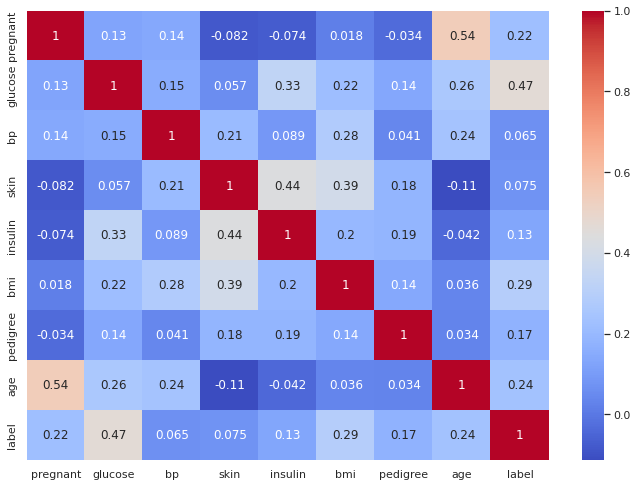

In [8]:
# set figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})
# generate a heatmap
sns.heatmap(df.corr(), annot=True,cmap='coolwarm')

Explore the invidual relationship of each variable pair with **pairplots**:  
(*in this case it does not help much, as there are too many variables*)

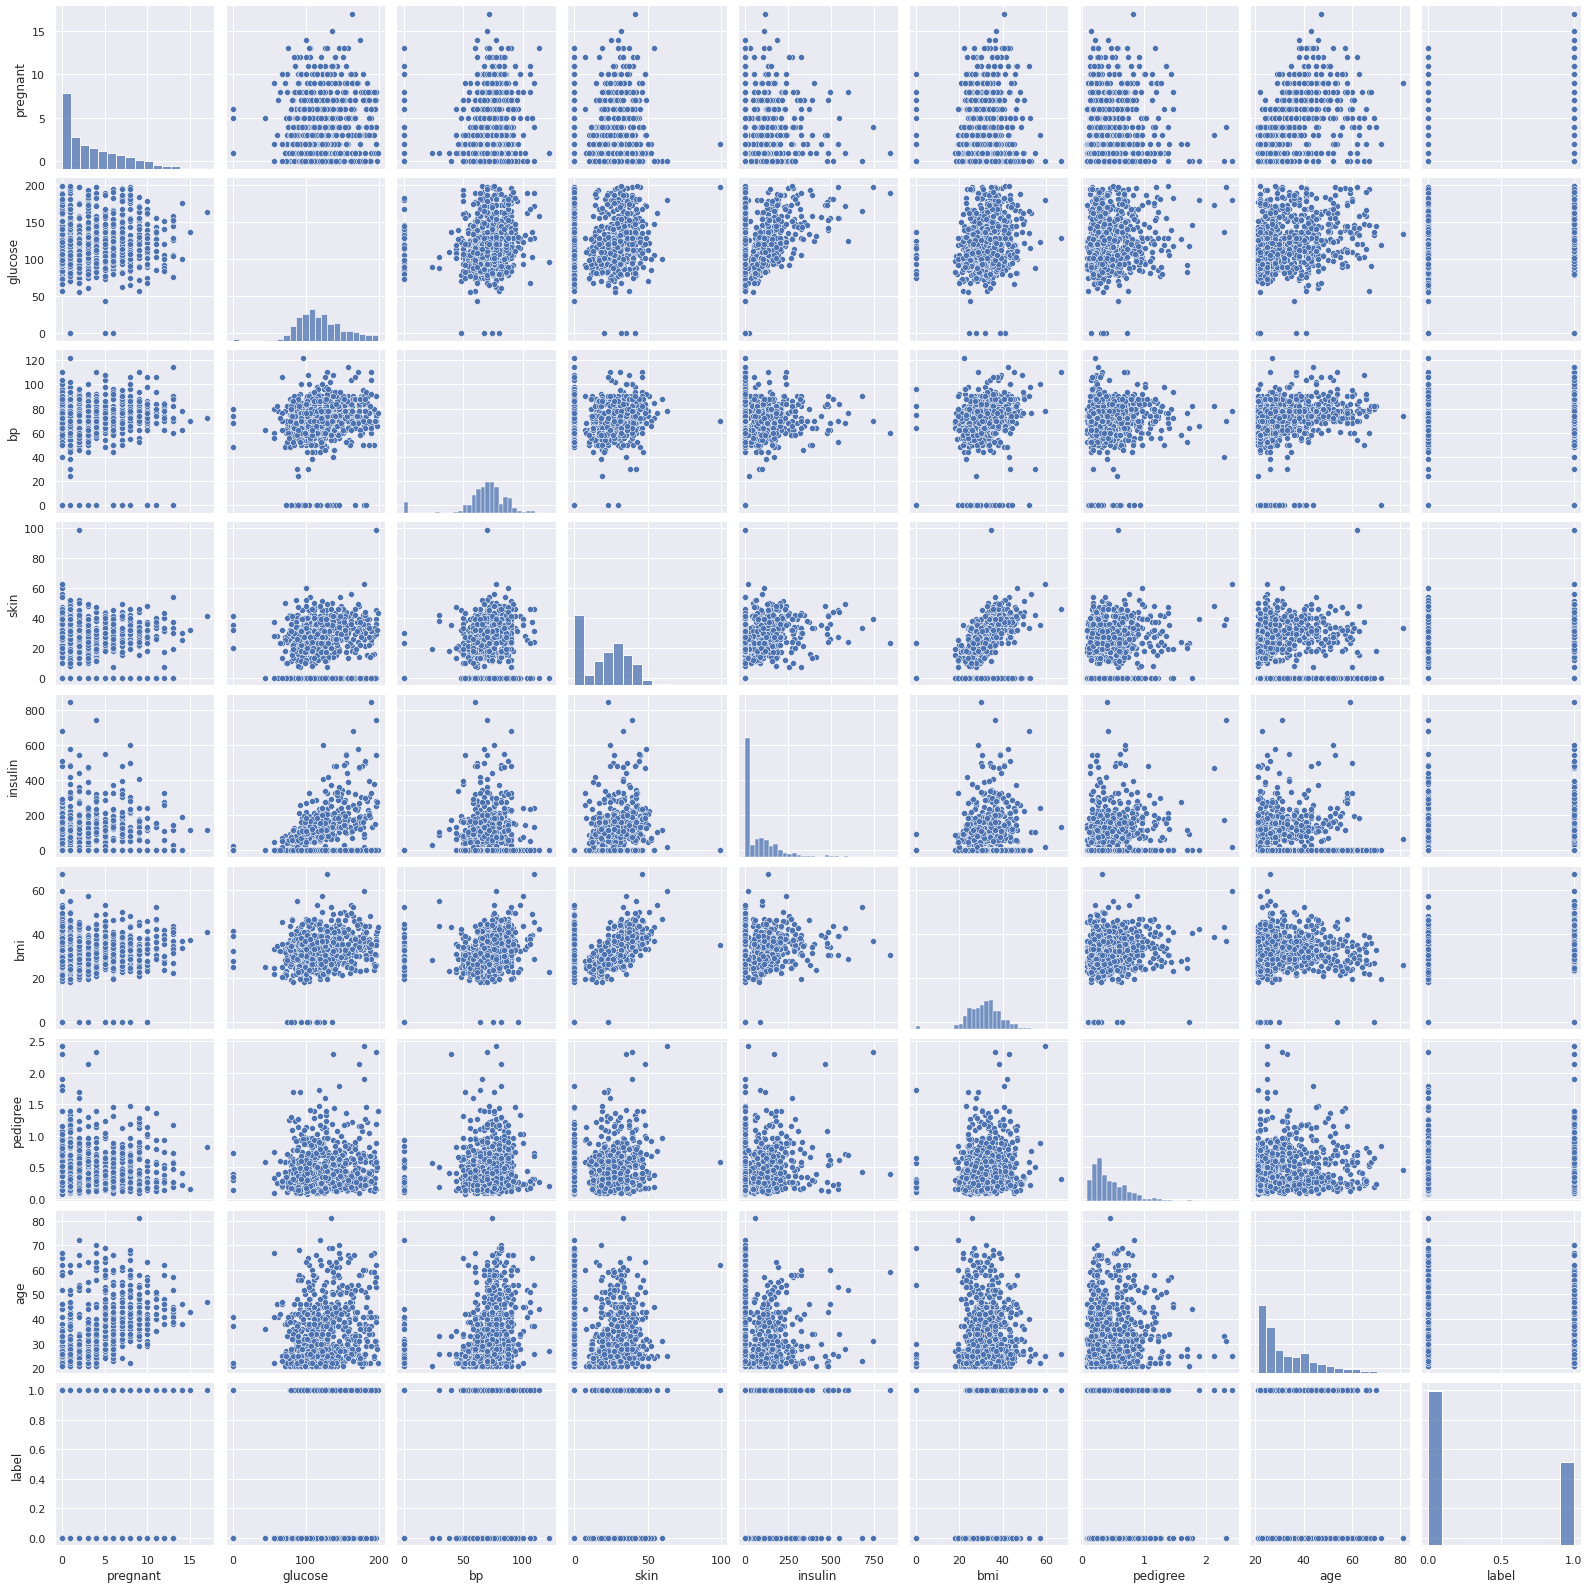

In [9]:
# set figure size
sns.set(rc={'figure.figsize':(5,5)})
sns.pairplot(df)

1. Assign Xs (features) & y (target) 
2. Convert them from pandas DataFrame (matrix) and pandas Series (single column) to ***numpy 2- and 1-Dimensional numpy arrays***, respectively.

  Pandas DataFrames & Series are easier to read by a human, but numpy's arrays are ***easier to handled by the computer***.  

In [10]:
# from df drop the specified variable, axis=1: drop the whole column
X = df.drop(columns='label', axis=1)
# convert pandas dataframe to a 2-Dimensional numpy array
X = X.values
# confirm that X's shape is 2D
print(X.shape)

# assing target
y = df['label']
# convert pandas series to a 1-Dimensional numpy array
y = y.values
# confirm that y's shape is 1D
print(y.shape)

(768, 8)
(768,)


<a name='GS'> </a>
 # **Hyperparameter Optimization**

In [11]:
# define the number of splits (train/test sets) and shuffle rows
kf = KFold(n_splits=10, shuffle=True, random_state=44)

# select a range to be tested for the number of trees variable
n_estimators = list(range(1,101))

# set the parameters of the gridsearch
param_grid = {
              'n_estimators': n_estimators,
              }

# select algorithm
model = RandomForestClassifier()

# set the gridsearch
gs = GridSearchCV(model, param_grid, cv=kf, verbose=3)

# train the gs
gs.fit(X, y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10] END ...................n_estimators=1;, score=0.727 total time=   0.0s
[CV 2/10] END ...................n_estimators=1;, score=0.701 total time=   0.0s
[CV 3/10] END ...................n_estimators=1;, score=0.792 total time=   0.0s
[CV 4/10] END ...................n_estimators=1;, score=0.597 total time=   0.0s
[CV 5/10] END ...................n_estimators=1;, score=0.623 total time=   0.0s
[CV 6/10] END ...................n_estimators=1;, score=0.558 total time=   0.0s
[CV 7/10] END ...................n_estimators=1;, score=0.753 total time=   0.0s
[CV 8/10] END ...................n_estimators=1;, score=0.636 total time=   0.0s
[CV 9/10] END ...................n_estimators=1;, score=0.697 total time=   0.0s
[CV 10/10] END ..................n_estimators=1;, score=0.632 total time=   0.0s
[CV 1/10] END ...................n_estimators=2;, score=0.701 total time=   0.0s
[CV 2/10] END ...................n_estimator

GridSearchCV(cv=KFold(n_splits=10, random_state=44, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...]},
             verbose=3)

Check what is the **best number of trees suggested by the GS**:

In [12]:
# suggest parameters by GS
print(gs.best_params_)

# best score by best params
print(gs.best_score_)

{'n_estimators': 59}
0.7708475734791523


Plot an **elbow graph** to visualize the best number of trees to be used:

Text(0.5, 1.0, 'Elbow Graph')

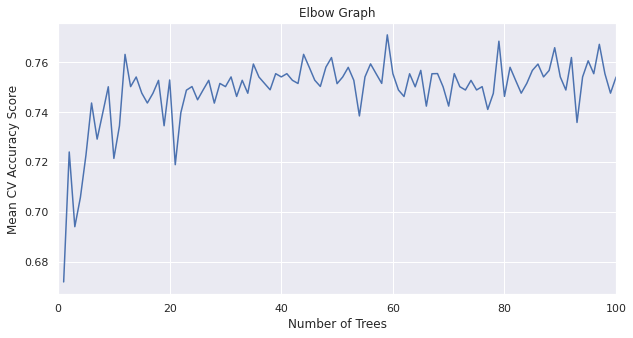

In [13]:
# extract the mean test scores of the gs
scores = gs.cv_results_['mean_test_score']

# plot the results as an elbow graph
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(n_estimators, scores)
plt.xlim(0, 100)
plt.xlabel("Number of Trees")
plt.ylabel("Mean CV Accuracy Score")
plt.title("Elbow Graph")

The **optimal value** of trees seems to be around 20.

Build & assess a RF model with 20 trees:

In [14]:
# build the model
model = RandomForestClassifier(n_estimators=20)

scores = []
for train_index, test_index in kf.split(X):
  # split the data
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  # train the model
  model.fit(X_train, y_train)
  scores.append(model.score(X_test, y_test))
  
print(round(np.mean(scores), 4))

0.7643


<a name="PostPruning"> </a>
# **Post-Pruning**

Find if there are features that are not significant contributors to our predictions. 

Find the most **important features** of our dataset:

In [15]:
# build the model
model = RandomForestClassifier(n_estimators=27)

for train_index, test_index in kf.split(X):
  # split the data
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  # train the model
  model.fit(X_train, y_train)

# convert the list of feature names to array
X_names = np.array(col_names)
# delete the target variable from the array
X_names = np.delete(X_names, 8)
# create a column with the importance of features from most to least important
ft_imp = pd.Series(model.feature_importances_, index=X_names).sort_values(ascending=False)
# print the list
ft_imp.head(8)

glucose     0.239801
bmi         0.164139
age         0.139767
pedigree    0.119587
bp          0.098291
pregnant    0.089583
skin        0.077775
insulin     0.071059
dtype: float64

Remove the features that contribute the least in order to **simplify** our model:

In [16]:
# from df drop the specified variable, axis=1: drop the whole column
X2 = df.drop(columns=['skin', 'insulin', 'label'], axis=1)
# convert df to array
X2 = X2.values
# from df drop the specified variable, axis=1: drop the whole column
y = df['label']
# convert series to array
y = y.values

# **Hyperparameter Optimization #2**

Fit gs to the reduced features dataset:

In [17]:
# train the gs
gs.fit(X2, y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10] END ...................n_estimators=1;, score=0.701 total time=   0.0s
[CV 2/10] END ...................n_estimators=1;, score=0.701 total time=   0.0s
[CV 3/10] END ...................n_estimators=1;, score=0.649 total time=   0.0s
[CV 4/10] END ...................n_estimators=1;, score=0.649 total time=   0.0s
[CV 5/10] END ...................n_estimators=1;, score=0.662 total time=   0.0s
[CV 6/10] END ...................n_estimators=1;, score=0.740 total time=   0.0s
[CV 7/10] END ...................n_estimators=1;, score=0.727 total time=   0.0s
[CV 8/10] END ...................n_estimators=1;, score=0.649 total time=   0.0s
[CV 9/10] END ...................n_estimators=1;, score=0.658 total time=   0.0s
[CV 10/10] END ..................n_estimators=1;, score=0.763 total time=   0.0s
[CV 1/10] END ...................n_estimators=2;, score=0.636 total time=   0.0s
[CV 2/10] END ...................n_estimator

GridSearchCV(cv=KFold(n_splits=10, random_state=44, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...]},
             verbose=3)

Evaluate GS results:

In [18]:
# suggest parameters by GS
print(gs.best_params_)

# best score by best params
print(gs.best_score_)

{'n_estimators': 76}
0.7722317156527683


Plot an **elbow graph** to find the optimal value of estimators:

Text(0.5, 1.0, 'Elbow Graph')

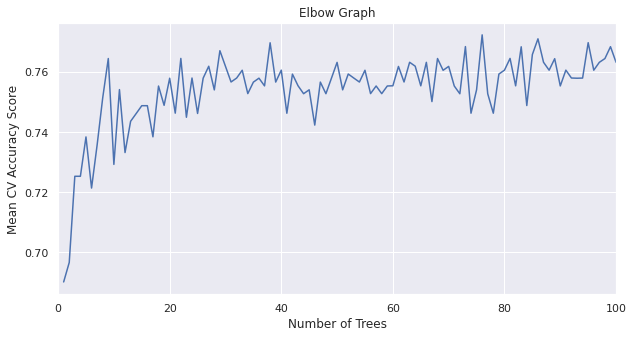

In [19]:
# extract the mean test scores of the gs
scores = gs.cv_results_['mean_test_score']

# plot the results as an elbow graph
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(n_estimators, scores)
plt.xlim(0, 100)
plt.xlabel("Number of Trees")
plt.ylabel("Mean CV Accuracy Score")
plt.title("Elbow Graph")

The **optimal value** seems to ~25 trees.

In [20]:
# build the model
model = RandomForestClassifier(n_estimators=25)

scores = []
for train_index, test_index in kf.split(X2):
  # split the data
  X_train, X_test = X2[train_index], X2[test_index]
  y_train, y_test = y[train_index], y[test_index]
  # train the model
  model.fit(X_train, y_train)
  scores.append(model.score(X_test, y_test))
  
print(round(np.mean(scores), 4))

0.7748


<a name='Conclusions'> </a>
# **Conclusions**
1. The **full-** & the **simplified-features** dataset had exactly the **mean cross-validated testing accuracy** (~77%) !

  Hence, the removed variables, i.e. skin & insulin, did not contribute significantly to our predictions.

2. The **elbow graph** is probably more efficient than **GridSearch** for deciding what the **best number of estimators** is, as the latter suggested a considerably higher number of trees both times.